**Vehicle Detection Project**

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

In [286]:
# Imports
import numpy as np
import pickle
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import glob
import time
import random
from scipy.ndimage.measurements import label
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skimage.feature import hog
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
print('Packages Imported')

Packages Imported


In [287]:
# Load Data
carImagesF = glob.glob('vehicles/**/*.png')
nonCarImagesF = glob.glob('non-vehicles/**/*.png')
print('Number of Car Images:',len(carImagesF))
print('Number of Non-Car Images:',len(nonCarImagesF))
figGridWidth = 4 # How many columns in figures grid - keep it even
nTestImages = 16 # Number of images from each set to carry out section tests on, keep it even and multiples of figGridWidth
carTestImages = []
carTestImagesIndex = []
nonCarTestImages = []
nonCarTestImagesIndex = []
for idx in np.arange(nTestImages):
    #Car Images
    carTestImagesIndex.append(random.randint(0,len(carImagesF)))
    img = cv2.imread(carImagesF[carTestImagesIndex[idx]])
    carTestImages.append(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
    #Non-Car Images
    nonCarTestImagesIndex.append(random.randint(0,len(nonCarImagesF)))
    img = cv2.imread(nonCarImagesF[nonCarTestImagesIndex[idx]])
    nonCarTestImages.append(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
carTestImagesIndex = np.array(carTestImagesIndex)
nonCarTestImagesIndex = np.array(nonCarTestImagesIndex)
print('Number of Test Images: ', nTestImages)

Number of Car Images: 8792
Number of Non-Car Images: 8968
Number of Test Images:  16


## Step 0 Visualize Data

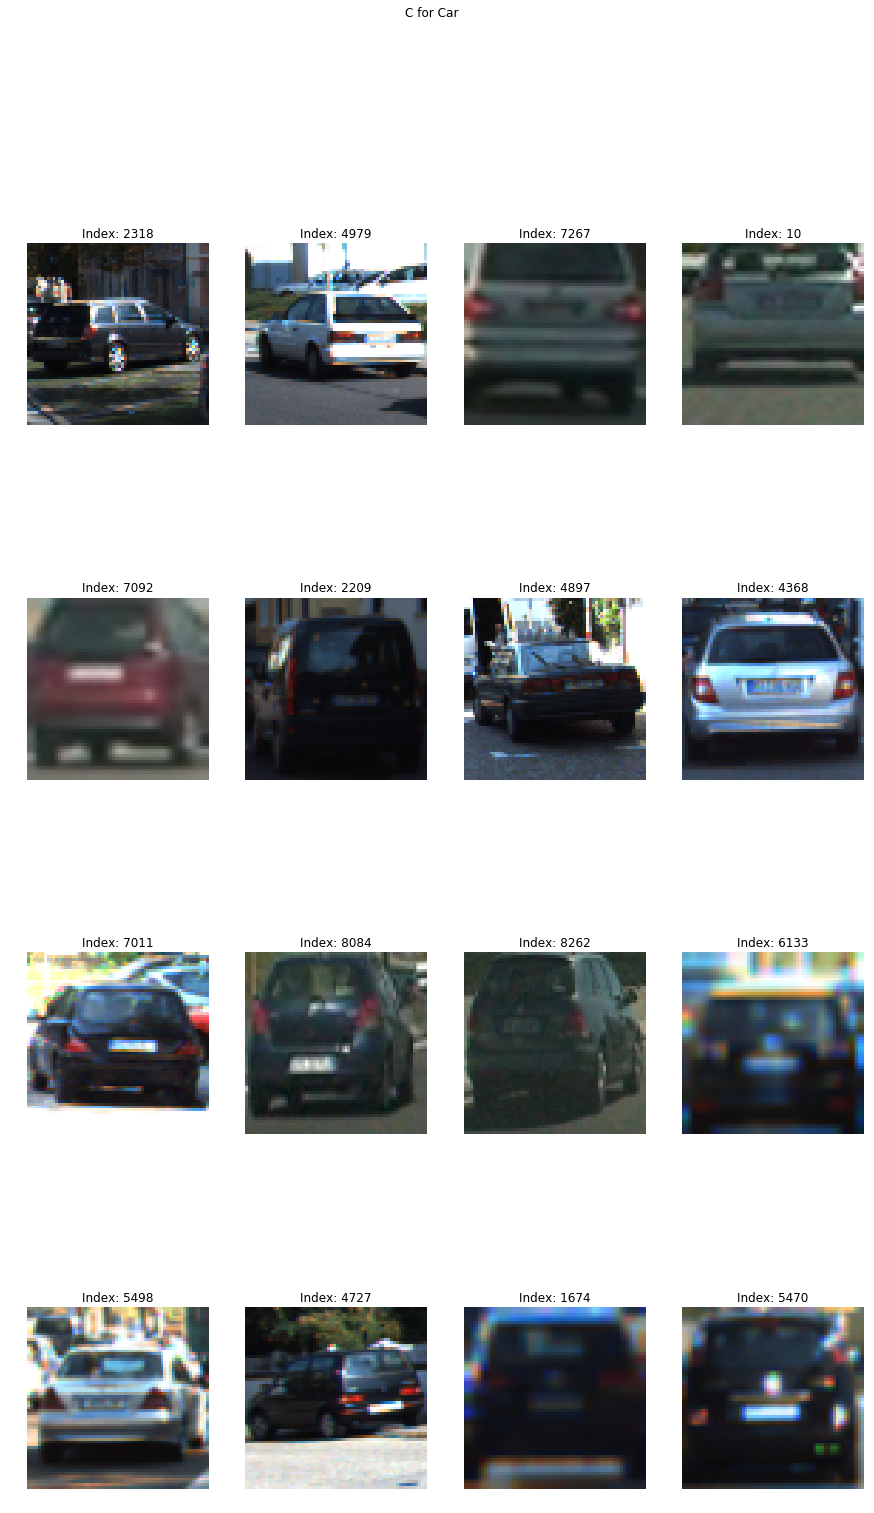

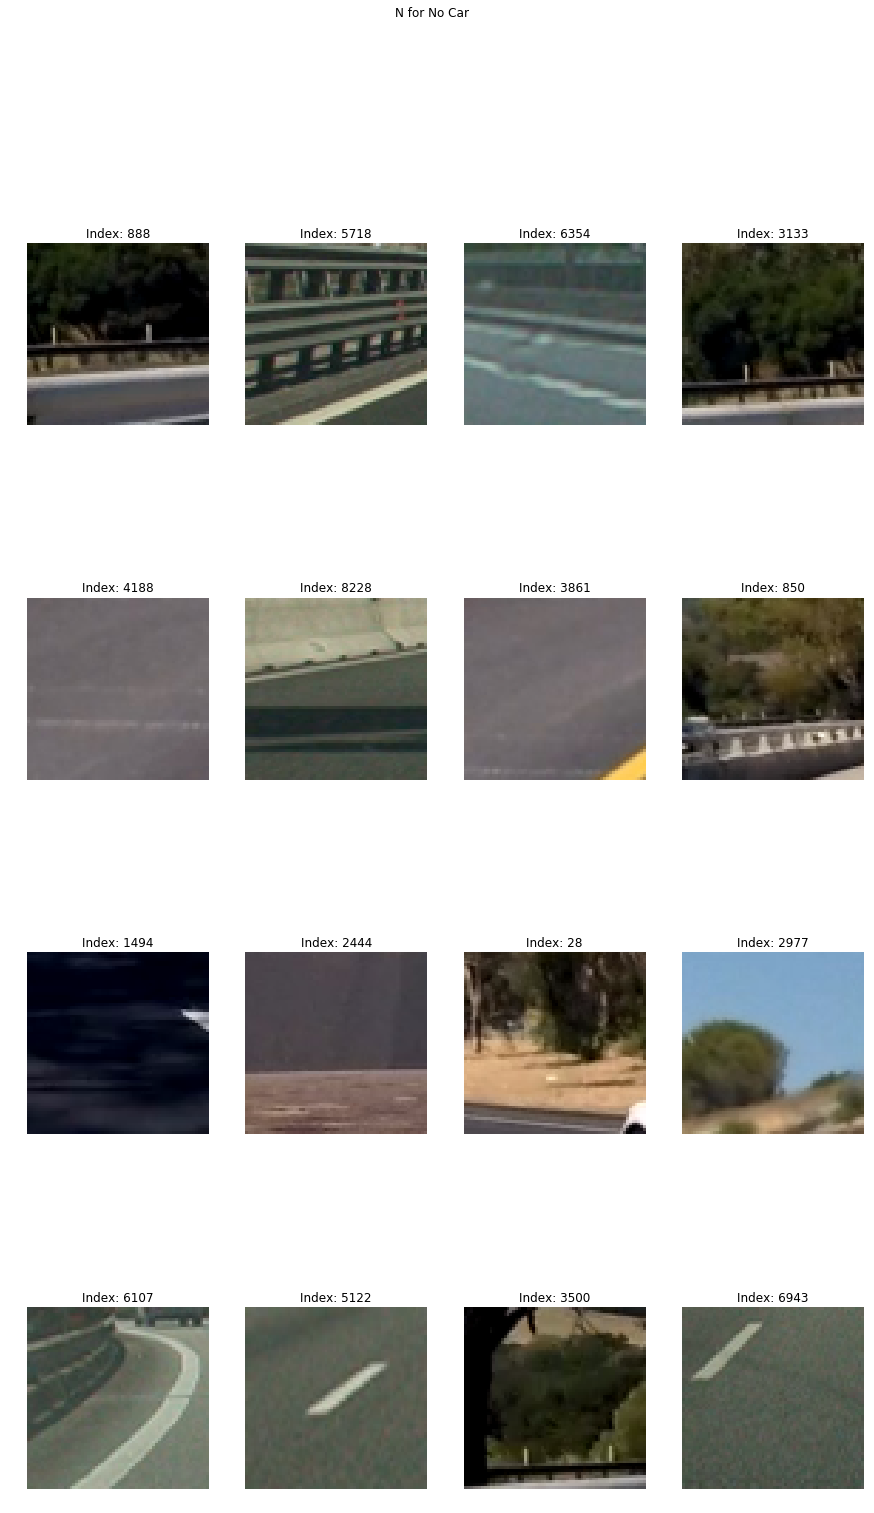

In [288]:
# Visualize a random set of car photos
figGridHeight = int(nTestImages/figGridWidth)
fig, axes = plt.subplots(figGridHeight,figGridWidth, figsize = (15,25))
fig.suptitle('C for Car')
for num, ax in enumerate(axes.flat):
        ax.imshow(carTestImages[num])
        ax.set_title('Index: {}'.format(carTestImagesIndex[num]))
        ax.axis('off')

# Visualize a random set of non-car photos
fig, axes = plt.subplots(figGridHeight,figGridWidth, figsize = (15,25))
fig.suptitle('N for No Car')
for num, ax in enumerate(axes.flat):
        ax.imshow(nonCarTestImages[num])
        ax.set_title('Index: {}'.format(nonCarTestImagesIndex[num]))
        ax.axis('off')

## Step 1A. Features: Histogram of Color

In [289]:
# A function to return HOC features - from lesson
def getHOCFeatures(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return rhist, ghist, bhist, bin_centers, hist_features

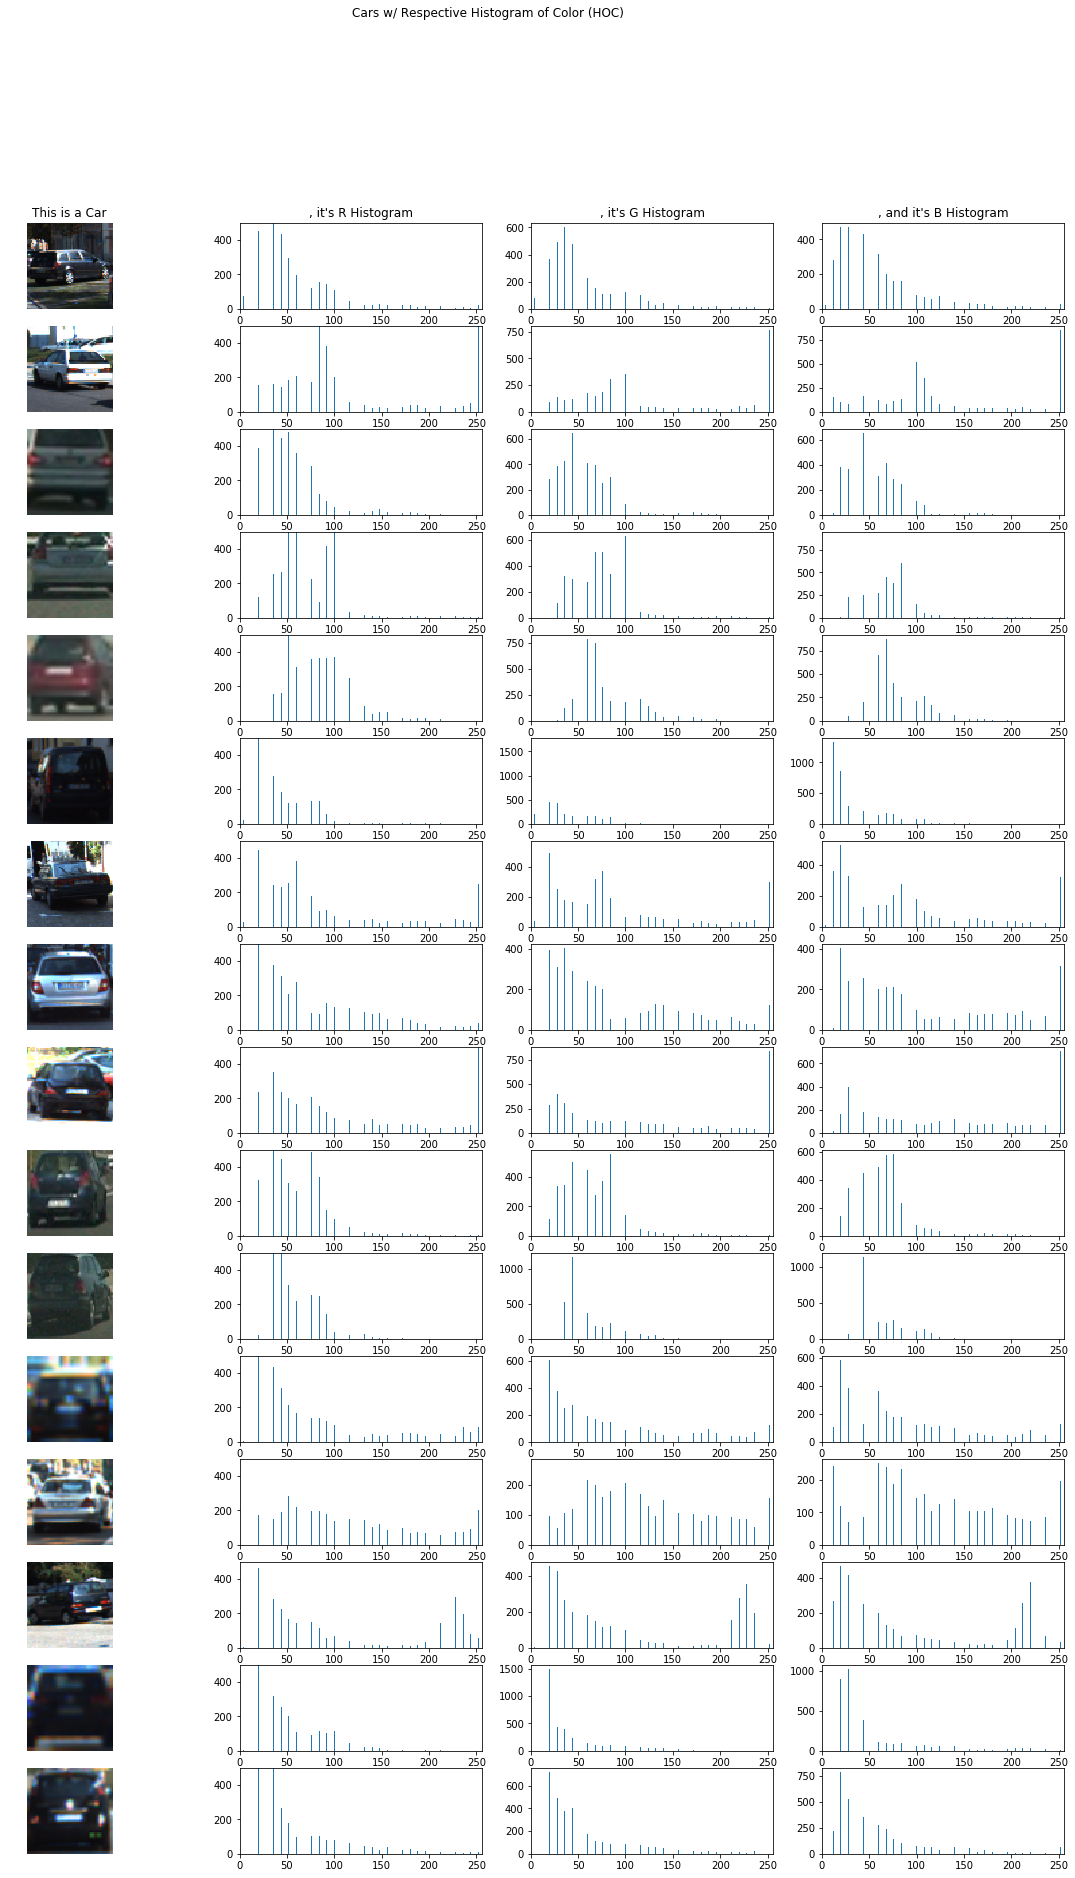

In [290]:
# Test HOC Features
nbins = 32
bins_range = (0, 256)
carHOCTestData = []
for carImage in carTestImages:
    rh, gh, bh, bincen, feature_vec = getHOCFeatures(carImage, nbins=nbins, bins_range=bins_range)
    carHOCTestData.append([rh, gh, bh, bincen, feature_vec])
carHOCTestData = np.array(carHOCTestData)

fig, axes = plt.subplots(figGridHeight * 4,figGridWidth, figsize = (20,30))
fig.suptitle('Cars w/ Respective Histogram of Color (HOC)')
for num, ax in enumerate(axes.flat):
    
    if num%4 == 0: 
        ax.imshow(carTestImages[int(num/4)])
        if num == 0:
            ax.set_title('This is a Car')
        ax.axis('off')
    elif num%4 == 1:
        ax.bar(carHOCTestData[int((num-1)/4)][3], carHOCTestData[int((num-1)/4)][0][0])
        if num == 1:
            ax.set_title(', it\'s R Histogram')
        ax.set_xlim(0, 256)
        ax.set_ylim(0,500)
    elif num%4 == 2:
        ax.bar(carHOCTestData[int((num-2)/4)][3], carHOCTestData[int((num-2)/4)][1][0])
        if num == 2:
            ax.set_title(', it\'s G Histogram')
        ax.set_xlim(0, 256)
    elif num%4 == 3:
        ax.bar(carHOCTestData[int((num-3)/4)][3], carHOCTestData[int((num-3)/4)][2][0])
        if num == 3:
            ax.set_title(', and it\'s B Histogram')
        ax.set_xlim(0, 256)


## Step 1B. Spatial Binning of Colorspace

In [291]:
# A function to perform colorspace binning - from lesson
def binSpatial(img, colorSpace = 'RGB', size = (32,32), Visualize = False):
    # Convert image to new color space (if specified)
    if colorSpace != 'RGB':
        if colorSpace == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif colorSpace == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif colorSpace == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif colorSpace == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif colorSpace == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    if Visualize:
        img = cv2.resize(feature_image, size)
        features = img.ravel()
        return img, features
    else:
        features = cv2.resize(feature_image, size).ravel()
        return features

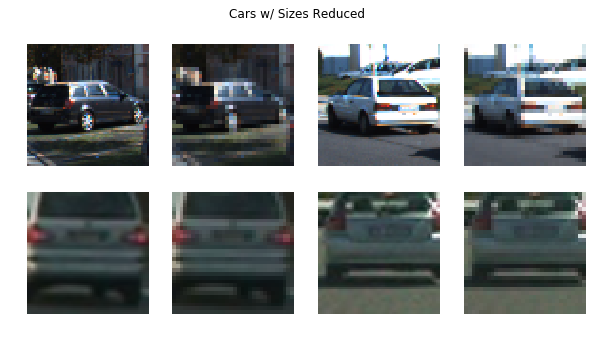

In [292]:
# Test Spatial Binning, on a few images

nTestSpatial = 4

imgSpatialTest = []
for test in np.arange(nTestSpatial):
    img, features = binSpatial(carTestImages[test], colorSpace = 'RGB', size = (32,32), Visualize = True)
    imgSpatialTest.append(img)
    
fig, axes = plt.subplots(int(nTestSpatial/figGridWidth *2) ,figGridWidth, figsize = (10,5))
fig.suptitle('Cars w/ Sizes Reduced')
for num, ax in enumerate(axes.flat):
    if num%2 == 0: 
        ax.imshow(carTestImages[int(num/2)])
        ax.axis('off')
    elif num%2 == 1:
        ax.imshow(imgSpatialTest[int((num-1)/2)])
        ax.axis('off')

## Step 1C. Features: Histogram of Oriented Gradients

In [293]:
# A function to return HOG features - from lesson
def getHOGFeatures(img, orient, pxpCell, clpBlock, Visualize = True, feature_vec= True):
    if Visualize:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pxpCell, pxpCell), cells_per_block=(clpBlock, clpBlock), 
                                  transform_sqrt=False, visualise=True, feature_vector = feature_vec)
        return features, hog_image
    else:
        features = hog(img, orientations=orient, pixels_per_cell=(pxpCell, pxpCell), cells_per_block=(clpBlock, clpBlock), 
                       transform_sqrt=False, visualise=False, feature_vector = feature_vec)
        return features  

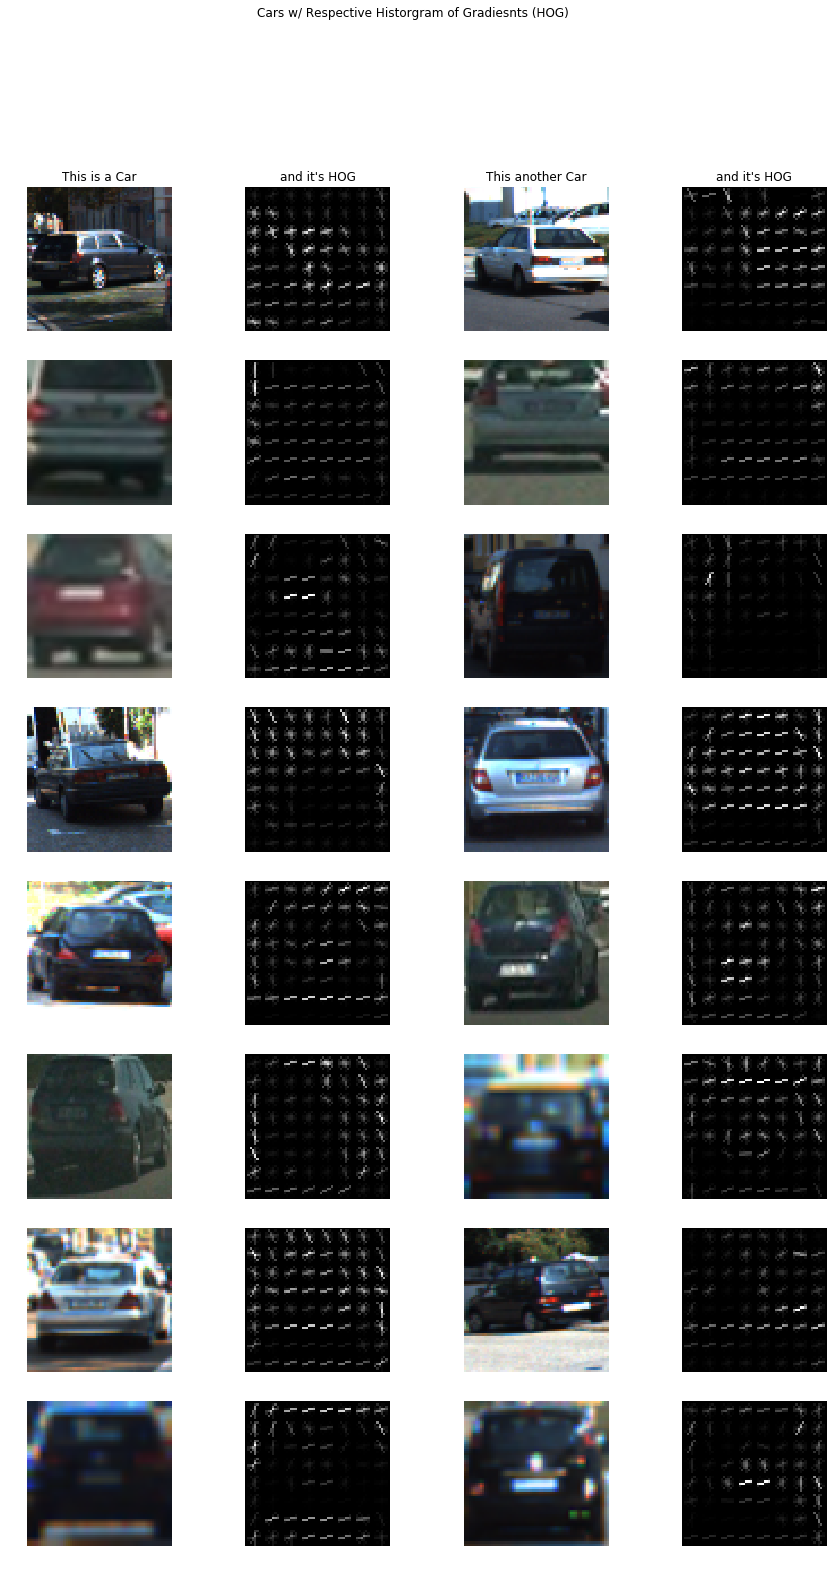

In [294]:
# Test HOG Features
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
carHOGTestImages = []
for carImage in carTestImages:
    carImageGray = cv2.cvtColor(carImage, cv2.COLOR_RGB2GRAY)
    # Call our function with vis=True to see an image output
    features, hog_image = getHOGFeatures(carImageGray, orient, 
                        pix_per_cell, cell_per_block, 
                        Visualize=True)
    carHOGTestImages.append(hog_image)

fig, axes = plt.subplots(figGridHeight * 2,figGridWidth, figsize = (15,25))
fig.suptitle('Cars w/ Respective Historgram of Gradiesnts (HOG)')
for num, ax in enumerate(axes.flat):
    if num%2 == 0: 
        ax.imshow(carTestImages[int(num/2)])
        if num == 0:
            ax.set_title('This is a Car')
        if num == 2:
            ax.set_title('This another Car')
        ax.axis('off')
    else:
        ax.imshow(carHOGTestImages[int((num-1)/2)], cmap = 'gray')
        if num == 1 or num == 3:
            ax.set_title('and it\'s HOG')
        ax.axis('off')

## Step 2. Combining Features 

In [295]:
# A function to extract features - from lesson
def extractColorFeatures(imageFiles, cspace='RGB', spatialSize=(32, 32), histBins=32, histRange=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imageFiles:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = binSpatial(feature_image, size=spatialSize)
        # Apply color_hist() also with a color space option now
        rh, gh, bh, bincen, hist_features = getHOCFeatures(feature_image, nbins=histBins, bins_range=histRange)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features)))
    # Return list of feature vectors
    return features

def extractGradientFeatures(imageFiles, cspace='RGB', orient=9, pxpCell=8, clpBlock=2, hogChannel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imageFiles:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hogChannel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(getHOGFeatures(feature_image[:,:,channel], orient, pxpCell, clpBlock, Visualize=False))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = getHOGFeatures(feature_image[:,:,hogChannel], orient, pxpCell, clpBlock, Visualize=False)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

def extractFeatures(imageFiles, cspace='RGB', spatialSize=(32, 32),histBins=32, histRange=(0, 256), orient=9, pxpCell=8, clpBlock=2, hogChannel=0,
                        spatialFeat=False, histFeat=True, hogFeat=False, singleImage = False):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    if singleImage:
        image = imageFiles
        imageFiles = [1]
    for file in imageFiles:
        file_features = []
        # Read in each one by one
        imageFiles
        if singleImage == False:
            image = mpimg.imread(file)

        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatialFeat == True:
            spatialFeatures = binSpatial(feature_image, size=spatialSize)
            file_features.append(spatialFeatures)
        if histFeat == True:
            # Apply color_hist()
            rh, gh, bh, bincen, histFeatures = getHOCFeatures(feature_image, nbins=histBins)
            file_features.append(histFeatures)
        if hogFeat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hogChannel == 'ALL':
                hogFeatures = []
                for channel in range(feature_image.shape[2]):
                    hogFeatures.append(getHOGFeatures(feature_image[:,:,channel], orient, pxpCell, clpBlock, Visualize=False))
                hogFeatures = np.ravel(hogFeatures)        
            else:
                hogFeatures = getHOGFeatures(feature_image[:,:,hogChannel], orient, pxpCell, clpBlock, Visualize=False)
            # Append the new feature vector to the features list
            file_features.append(hogFeatures)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

## Step 3. Traing a Classifier

###  Color Feature Extraction and Classification Expolation
Will iterate over a number of colorspaces, spatial and histogram sizes and record the accuracy performance

Using LUV Color Space
Using spatial binning of: 16 and 32 histogram bins
Feature vector length: 864
6.68 Seconds to train SVC...
Test Accuracy of SVC =  0.9589
My SVC predicts:  [ 1.  1.  0.  1.  0.  1.  0.  1.  0.  0.]
For these 10 labels:  [ 1.  1.  0.  1.  0.  1.  0.  1.  0.  0.]
0.00197 Seconds to predict 10 labels with SVC


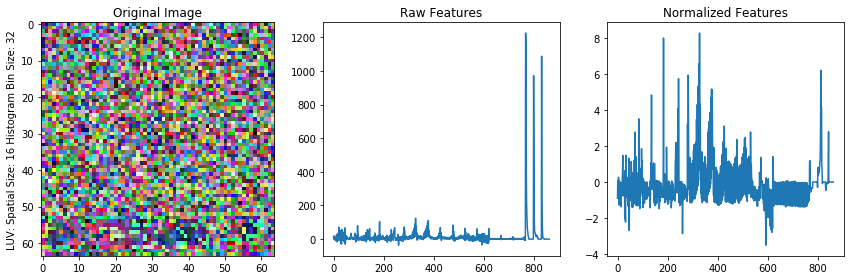

In [296]:
import time
ExploreColorExtraction = False
if ExploreColorExtraction:
    spatialSizes = [16, 32, 64]
    histBins = [16, 32, 64]
    colorSpaces = ['RGB', 'LUV', 'HSV', 'YUV', 'HLS']
else:
    # Best Combination Found
    spatialSizes = [16]
    histBins = [32]
    colorSpaces = ['LUV']
        

histRange=(0, 256)
carColorFeatures = []
nonCarColorFeatures = []
carInd = np.random.randint(0, len(carImagesF))
for num, colorSpace in enumerate(colorSpaces):
    for spatialSize, histBin in zip(spatialSizes, histBins):
        
        carColorFeatures = extractColorFeatures(carImagesF, cspace=colorSpace, spatialSize = (spatialSize, spatialSize), histBins = histBin, histRange = histRange)
        nonCarColorFeatures = extractColorFeatures(nonCarImagesF, cspace=colorSpace, spatialSize = (spatialSize, spatialSize), histBins = histBin, histRange = histRange)

        # Normalize Features
        time.sleep(2)
        if len(carColorFeatures) > 0:
            plt.ion()
            plt.show()
            # Create an array stack of feature vectors
            X = np.vstack((carColorFeatures, nonCarColorFeatures)).astype(np.float64)                        
            # Fit a per-column scaler
            X_scaler = StandardScaler().fit(X)
            # Apply the scaler to X
            scaled_X = X_scaler.transform(X)
            # Plot an example of raw and scaled features
            fig = plt.figure(figsize=(12,4))
            plt.subplot(131)
            img = mpimg.imread(carImagesF[carInd])
            if colorSpace != 'RGB':
                if colorSpace == 'HSV':
                    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
                elif colorSpace == 'LUV':
                    img = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
                elif colorSpace == 'HLS':
                    img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
                elif colorSpace == 'YUV':
                    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
                elif colorSpace == 'YCrCb':
                    img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
            plt.imshow(img)
            plt.title('Original Image')
            str = colorSpace + ': ' + 'Spatial Size: {} Histogram Bin Size: {}'.format(spatialSize, histBin)
            plt.ylabel(str)
            plt.subplot(132)
            plt.plot(X[carInd])
            plt.title('Raw Features')
            plt.subplot(133)
            plt.plot(scaled_X[carInd])
            plt.title('Normalized Features')
            fig.tight_layout()
            plt.pause(2)
            
            #input("Press [enter] to continue.")
            # Train Data
            # Define Labels Vector
            y = np.hstack((np.ones(len(carColorFeatures)), np.zeros(len(nonCarColorFeatures))))
            # Split training from validation
            rand_state = np.random.randint(0, 100)
            X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

            print('Using {} Color Space'.format(colorSpace))
            print('Using spatial binning of:',spatialSize, 'and', histBin,'histogram bins')
            print('Feature vector length:', len(X_train[0]))
            # Use a linear SVC 
            svc = LinearSVC()
            # Check the training time for the SVC
            t=time.time()
            svc.fit(X_train, y_train)
            t2 = time.time()
            print(round(t2-t, 2), 'Seconds to train SVC...')
            # Check the score of the SVC
            print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
            # Check the prediction time for a single sample
            t=time.time()
            n_predict = 10
            print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
            print('For these',n_predict, 'labels: ', y_test[0:n_predict])
            t2 = time.time()
            print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')


### Exploring Color Space And Color Histogram Feature Extraction - Noted Results
Note: Displayed Images for non-RGB colorspaces don't reflect the feature (they're meaningless to look at) but each separate channel will be more useful.

| Test | ColorSpace | Spatial Size | Histogram Bin Size | Feature Vector Length | Test Accuracy | Training Time (s) | Predict Time for 10 Labels (s) |
|------|------------|--------------|--------------------|-----------------------|---------------|-------------------|--------------------------------|
| 1    | RGB        | 16           | 16                 | 816                   | 0.92          | 13.26             | 0.0018                         |
| 2    | RGB        | 32           | 32                 | 3168                  | 0.92          | 29.30             | 0.0019                         |
| 3    | RGB        | 64           | 64                 | 12480                 | 0.91          | 90.00             | 0.0047                         |
| 4    | LUV        | 16           | 16                 | 816                   | 0.95          | 8.51              | 0.0018                         |
| 5    | LUV        | 32           | 32                 | 3168                  | 0.94          | 17.00             | 0.0021                         |
| 6    | LUV        | 64           | 64                 | 12480                 | 0.93          | 59.00             | 0.0019                         |
| 7    | HSV        | 16           | 16                 | 816                   | 0.91          | 11.87             | 0.0019                         |
| 8    | HSV        | 32           | 32                 | 3168                  | 0.91          | 18.33             | 0.0019                         |
| 9    | HSV        | 64           | 64                 | 12480                 | 0.92          | 79.63             | 0.0134                         |
| 10   | YUV        | 16           | 16                 | 816                   | 0.93          | 13.75             | 0.0018                         |
| 11   | YUV        | 32           | 32                 | 3168                  | 0.90          | 22.00             | 0.0016                         |
| 12   | YUV        | 64           | 64                 | 12480                 | 0.90          | 77.00             | 0.0019                         |
| 13   | HLS        | 16           | 16                 | 816                   | 0.92          | 12.80             | 0.0019                         |
| 14   | HLS        | 32           | 32                 | 3168                  | 0.91          | 17.37             | 0.0020                         |
| 15   | HLS        | 64           | 64                 | 12480                 | 0.92          | 67.00             | 0.0019                         |


###  Gradient Feature Extraction and Classification Expolation
Will iterate over a number of colorspaces, orientation and pixels per cell and cell per block and record the accuracy performance

In [297]:
ExploreGradientExtraction = False
if ExploreGradientExtraction:
    orients = [9]
    pxpCells = [16]
    clpBlocks = [2]
    colorSpaces = ['RGB', 'LUV', 'HSV', 'YUV', 'HLS']
    hogChannels = ['ALL',   'ALL',    'ALL',      'ALL',     'ALL']

else:
    # Best Combination Found
    orients = [9]
    pxpCells = [8]
    clpBlocks = [2]
    colorSpaces = ['YCrCb']
    hogChannels = ['ALL']
    
carGradientFeatures = []
nonCarGradientFeatures = []
carInd = np.random.randint(0, len(carImagesF))
for colorSpace, hogChannel in zip(colorSpaces, hogChannels):
    for orient, pxpCell, clpBlock in zip(orients, pxpCells, clpBlocks):
        
        carGradientFeatures = extractGradientFeatures(carImagesF, colorSpace, orient, pxpCell, clpBlock, hogChannel)
        nonCarGradientFeatures = extractGradientFeatures(nonCarImagesF, colorSpace, orient, pxpCell, clpBlock, hogChannel) 
        # Normalize Features
        time.sleep(2)
        if len(carGradientFeatures) > 0:
            plt.ion()
            plt.show()
            # Create an array stack of feature vectors
            X = np.vstack((carGradientFeatures, nonCarGradientFeatures)).astype(np.float64)                        
            # Fit a per-column scaler
            X_scaler = StandardScaler().fit(X)
            # Apply the scaler to X
            scaled_X = X_scaler.transform(X)
            
            # Train Data
            # Define Labels Vector
            y = np.hstack((np.ones(len(carGradientFeatures)), np.zeros(len(nonCarGradientFeatures))))
            # Split training from validation
            rand_state = np.random.randint(0, 100)
            X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)
            
            print('Using:',colorSpace, ' Channel', hogChannel, ',', orient, 'orientations', pxpCell, 'pixels per cell and', clpBlock, 'cells per block')
            print('Feature vector length:', len(X_train[0]))
            # Use a linear SVC 
            svc = LinearSVC()
            # Check the training time for the SVC
            t=time.time()
            svc.fit(X_train, y_train)
            t2 = time.time()
            print(round(t2-t, 2), 'Seconds to train SVC...')
            # Check the score of the SVC
            print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
            # Check the prediction time for a single sample
            t=time.time()
            n_predict = 10
            print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
            print('For these',n_predict, 'labels: ', y_test[0:n_predict])
            t2 = time.time()
            print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')    

Using: YCrCb  Channel ALL , 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5292
10.96 Seconds to train SVC...
Test Accuracy of SVC =  0.9811
My SVC predicts:  [ 0.  1.  0.  1.  0.  0.  1.  0.  0.  0.]
For these 10 labels:  [ 0.  1.  0.  1.  0.  0.  1.  0.  0.  0.]
0.00197 Seconds to predict 10 labels with SVC


### Exploring Gradient Histogram Feature Extraction - Noted Results
| Test | ColorSpace | Hog Channel | Orient | Pixel Per Block | Cell Per Block | Feature Vector Length | Test Accuracy | Training Time (s) | Predict Time for 10 Labels (s) |
|:----:|:----------:|:-----------:|:------:|:---------------:|:--------------:|:---------------------:|:-------------:|:-----------------:|:------------------------------:|
|   1  |     RGB    |      R      |    7   |        8        |        1       |          448          |      0.94     |        7.13       |             0.0020             |
|   2  |     RGB    |      R      |    9   |        16       |        2       |          324          |      0.94     |        4.91       |             0.0018             |
|   3  |     RGB    |      R      |   11   |        12       |        3       |          891          |      0.94     |        9.56       |             0.0019             |
|   4  |     LUV    |      U      |    7   |        8        |        1       |          448          |      0.89     |       10.34       |             0.0018             |
|   5  |     LUV    |      U      |    9   |        16       |        2       |          324          |      0.93     |        5.89       |             0.0018             |
|   6  |     LUV    |      U      |   11   |        12       |        3       |          891          |      0.91     |       11.56       |             0.0019             |
|   7  |     HSV    |      S      |    7   |        8        |        1       |          448          |      0.89     |       10.71       |             0.0020             |
|   8  |     HSV    |      S      |    9   |        16       |        2       |          324          |      0.89     |        7.30       |             0.0020             |
|   9  |     HSV    |      S      |   11   |        12       |        3       |          891          |      0.88     |       14.49       |             0.0020             |
|  10  |     YUV    |      Y      |    7   |        8        |        1       |          448          |      0.95     |        5.50       |             0.0018             |
|  11  |     YUV    |      Y      |    9   |        16       |        2       |          324          |      0.94     |        4.25       |             0.0019             |
|  12  |     YUV    |      Y      |   11   |        12       |        3       |          891          |      0.95     |        8.15       |             0.0018             |
|  13  |     HLS    |      L      |    7   |        8        |        1       |          448          |      0.94     |        5.80       |             0.0018             |
|  14  |     HLS    |      L      |    9   |        16       |        2       |          324          |      0.95     |        4.50       |             0.0018             |
|  15  |     HLS    |      L      |   11   |        12       |        3       |          891          |      0.94     |        8.30       |             0.0018             |
|  16  |     RGB    |     ALL     |    9   |        16       |        2       |          972          |      0.96     |        4.42       |             0.0018             |
|  17  |     LUV    |     ALL     |    9   |        16       |        2       |          972          |      0.97     |        2.54       |             0.0018             |
|  18  |     HSV    |     ALL     |    9   |        16       |        2       |          972          |      0.97     |        2.14       |             0.0018             |
|  19*  |     YUV    |     ALL     |    9   |        16       |        2       |          972          |      0.98     |        1.78       |             0.0018             |
|  20  |     HLS    |     ALL     |    9   |        16       |        2       |          972          |      0.96     |        2.09       |             0.0018             |

### Train Combined Features - Processing Pipeline Starts from here, skip Exploration cells if you want

In [303]:
# Training Parameters
colorSpace = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pxpCell = 8 # HOG pixels per cell
clpBlock = 2 # HOG cells per block
hogChannel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatialSize = (32, 32) # Spatial binning dimensions
histBins = 32    # Number of histogram bins
spatialFeat = False # Spatial features on or off
histFeat = False # Histogram features on or off
hogFeat = True # HOG features on or off
histRange = (0, 256)


carFeatures    = extractFeatures(carImagesF, colorSpace, spatialSize, histBins, histRange, orient, pxpCell, clpBlock, hogChannel, spatialFeat, histFeat, hogFeat)
nonCarFeatures = extractFeatures(nonCarImagesF, colorSpace, spatialSize, histBins, histRange, orient, pxpCell, clpBlock, hogChannel, spatialFeat, histFeat, hogFeat)

X = np.vstack((carFeatures, nonCarFeatures)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(carFeatures)), np.zeros(len(nonCarFeatures))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell, 'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()


Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5292
12.17 Seconds to train SVC...
Test Accuracy of SVC =  0.9738


## Step 4. Sliding Window Search

In [304]:
def searchWindows(img, windows, clf, scaler, cspace='RGB', spatialSize=(32, 32), histBins=32, histRange=(0, 256), orient=9, pxpCell=8, clpBlock=2, 
                    hogChannel=0, spatialFeat=True, histFeat=True, hogFeat=True):
    
    #1) Create an empty list to receive positive detection windows
    onWindows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        testImg = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = extractFeatures(testImg, colorSpace, spatialSize, histBins, histRange, orient, pxpCell, clpBlock, hogChannel, spatialFeat, histFeat, hogFeat, singleImage = True)
        #5) Scale extracted features to be fed to classifier
        testFeatures = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(testFeatures)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            onWindows.append(window)
    #8) Return windows for positive detections
    return onWindows

def slideWindow(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def drawBoxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

Test on given test images


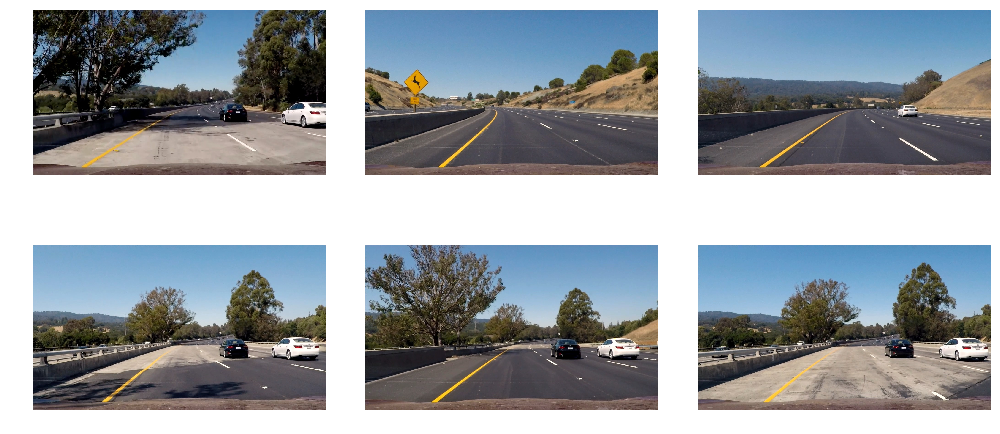

In [305]:

imageTestFiles = glob.glob('./test_images/test*.jpg')
windowImages = []

xyWindow = (64, 64)
xyOverlap = (0.5, 0.5)
y_start_stop = [380, 580] # Min and max in y to search in slide_window()
    
for imageTestFile in imageTestFiles:
    
    image = mpimg.imread(imageTestFile)
    drawImage = np.copy(image)


    windows = slideWindow(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=xyWindow, xy_overlap=xyOverlap)

    hotWindows = searchWindows(image, windows, svc, X_scaler, colorSpace, spatialSize, histBins, 
                               histRange, orient, pxpCell, clpBlock, hogChannel, spatialFeat, histFeat, hogFeat)                     

    windowImages.append(drawBoxes(drawImage, hotWindows, color=(0, 0, 255), thick=6))                    
print('Test on given test images')
fig, axes = plt.subplots(2,3, figsize = (14,7))
for ax, image in zip(axes.flat, windowImages):
        ax.imshow(image)
        ax.axis('off')
fig.tight_layout()

Some working settings:
colorSpace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11  # HOG orientations
pxpCell = 16 # HOG pixels per cell
clpBlock = 2 # HOG cells per block
hogChannel = 0 # Can be 0, 1, 2, or "ALL"
spatialSize = (16, 16) # Spatial binning dimensions
histBins = 16    # Number of histogram bins
spatialFeat = False # Spatial features on or off
histFeat = False # Histogram features on or off
hogFeat = True # HOG features on or off
histRange = (0, 256)
xyWindow = (64, 64)
xyOverlap = (0.5, 0.5)

Test on given test images


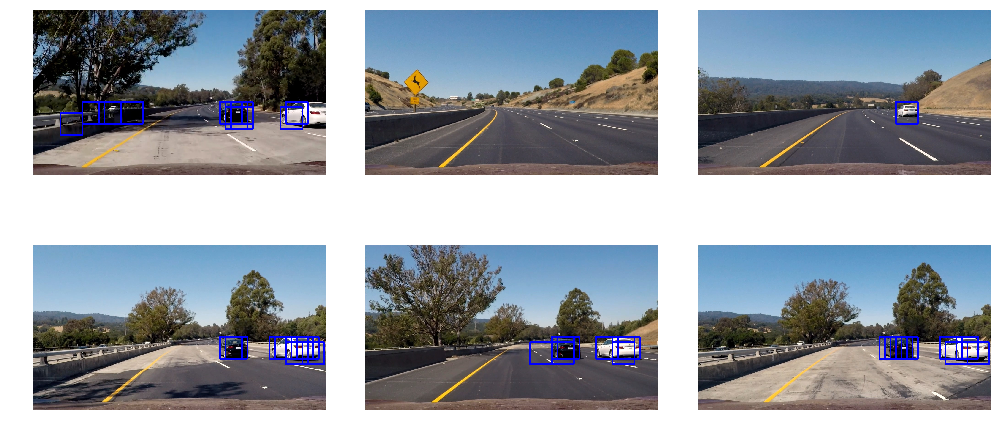

In [306]:
def convert_color(img, conv='YCrCb'):
    if conv == 'YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    elif conv == 'HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    elif conv == 'LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    elif conv == 'HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    elif conv == 'YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pxpCell, clpBlock, spatialSize, histBins, hogChannel = 0):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv=colorSpace)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    if hogChannel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else:
        ch1 = ctrans_tosearch[:,:,hogChannel]
            
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pxpCell) + 1 #- clpBlock + 1
    nyblocks = (ch1.shape[0] // pxpCell) + 1 #- clpBlock + 1 
    nfeat_per_block = orient*clpBlock**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pxpCell) - 1 #- clpBlock + 1
    cpStep = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cpStep
    nysteps = (nyblocks - nblocks_per_window) // cpStep
    
    # Compute individual channel HOG features for the entire image
    if hogChannel == 'ALL':
        hog1 = getHOGFeatures(ch1, orient, pxpCell, clpBlock, Visualize = False, feature_vec = False)
        hog2 = getHOGFeatures(ch2, orient, pxpCell, clpBlock, Visualize = False, feature_vec = False)
        hog3 = getHOGFeatures(ch3, orient, pxpCell, clpBlock, Visualize = False, feature_vec = False)
    else:
        hog = getHOGFeatures(ch1, orient, pxpCell, clpBlock, Visualize = False, feature_vec = False)
    rects = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cpStep
            xpos = xb*cpStep
            if hogChannel == 'ALL':
                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 

            xleft = xpos*pxpCell
            ytop = ypos*pxpCell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = binSpatial(subimg, size=spatialSize)
            rh, gh, bh, bincen, hist_features = getHOCFeatures(subimg, nbins=histBins)

            
            # Scale features and make a prediction
            #test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_features = X_scaler.transform(hog_features).reshape(1, -1)
            test_prediction = svc.predict(test_features)
            #test_prediction = svc.predict(hog_features)
            
            if test_prediction == 1:
            #if True:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rects.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                #draw_img = draw_boxes(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)) 
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)
                
    for rect in rects:
        # Draw the rectangles
        cv2.rectangle(draw_img, rect[0], rect[1],(0,0,255),6)
    return draw_img, rects
    
ystart = 400
ystop = 656
scale = 1.5
findCarImages = []
findCarBoxes = []
for imageTestFile in imageTestFiles:
    img = mpimg.imread(imageTestFile)
    image, boxes = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pxpCell, clpBlock, spatialSize, histBins, hogChannel)
    findCarImages.append(image)
    findCarBoxes.append(boxes)

print('Test on given test images')
fig, axes = plt.subplots(2,3, figsize = (14,7))
for ax, image in zip(axes.flat, findCarImages):
        ax.imshow(image)
        ax.axis('off')
fig.tight_layout()

## Step 5. Heat Map

Test on given test images


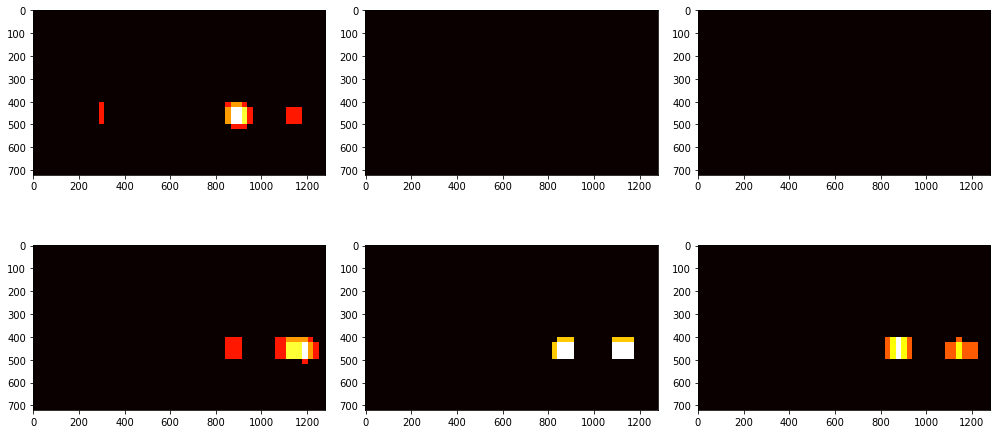

In [310]:
heat = np.zeros_like(image[:,:,0]).astype(np.float)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img



print('Test on given test images')
fig, axes = plt.subplots(2,3, figsize = (14,7))
for ax, image, boxes in zip(axes.flat, findCarImages, findCarBoxes):
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,boxes)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    ax.imshow(heatmap, cmap ='hot')
fig.tight_layout()

## Step 6. Integrate into Pipeline

In [ ]:
# Class to Save Vehicle Detectiion Locations
class Vehicles():
    def __init__(self):
        self.carID = 0 # Number Each Car, give it it's own class 
        self.centroidsn4 = [] # Previous 4 box center locations
        self.framesPresent = 0 # Number of frames vehicle is in view
        
        #Future
        self.avgSpeed = 0 # Estimated relative speed of detected vehicle
        self.lane = 0 # Lan vehicle is in 1 far left , 2 , 3, -1 for opposite direction
    
    def update(self, rects):
        #update class variables
    
    def get(self,data = 'carID'):
        if data == 'carID':
            return self.carID
        # etc for rest of data
        
def process(imageFrame):
    
    # Define SVC Parameters
    colorSpace = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 9  # HOG orientations
    pxpCell = 8 # HOG pixels per cell
    clpBlock = 2 # HOG cells per block
    hogChannel = 'ALL' # Can be 0, 1, 2, or "ALL"
    spatialSize = (32, 32) # Spatial binning dimensions
    histBins = 32    # Number of histogram bins
    spatialFeat = False # Spatial features on or off
    histFeat = False # Histogram features on or off
    hogFeat = True # HOG features on or off
    histRange = (0, 256)
    
    # 


## Final Step. Run the Classifier on the Video

In [ ]:


# Import Video Packages
from moviepy.editor import VideoFileClip
from IPython.display import HTML
